In [60]:
import glob
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Align import PairwiseAligner

In [2]:
def umi_histogram(fastq_path, max_count):
    conscount_values = []
    
    # Regular expression to find CONSCOUNT field and extract the number
    pattern = re.compile(r"CONSCOUNT=(\d+)")

    # Parse the fastq file
    with open(fastq_path, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            match = pattern.search(record.description)
            if match:
                conscount = int(match.group(1))
                # All values greater than max_count are set to max_count
                conscount = min(conscount, max_count)
                conscount_values.append(conscount)
    
    # Plot the histogram
    # bins should be one more than max_count to include the last bin
    plt.hist(conscount_values, bins=max_count+1, range=(0, max_count+1), edgecolor='black')
    
    fastq_basename = fastq_path.split('/')[-1]
    plt.title(f'Distribution of CONSCOUNT for {fastq_basename}')
    plt.xlabel('CONSCOUNT')
    plt.ylabel('Frequency')
    
    ticks = list(range(0, max_count + 1))
    labels = [str(i) for i in range(0, max_count)] + [f"=>{max_count}"]
    plt.xticks(ticks, labels, rotation=90)
    
    plt.show()


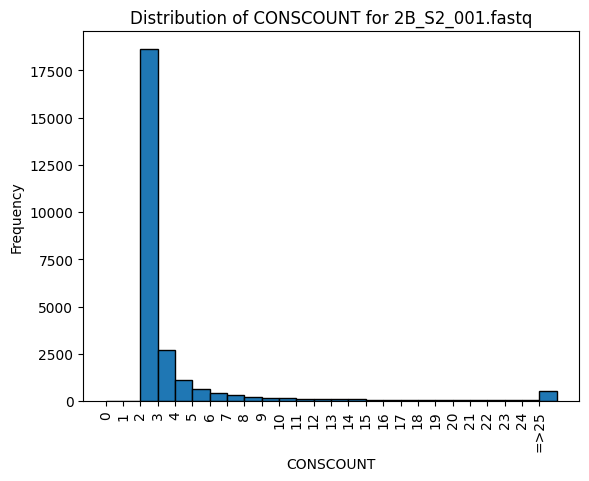

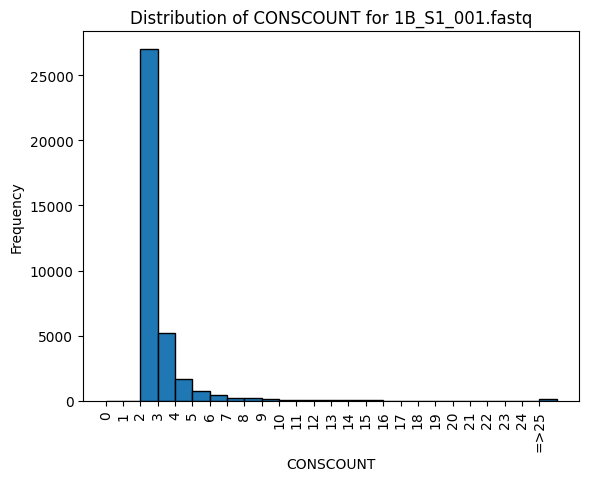

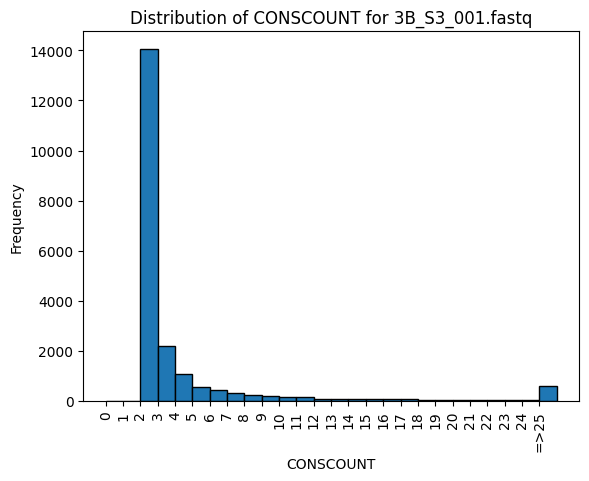

In [3]:
for path in glob.glob("/Users/matsen/re/gcreplay/nextflow/data/passenger/test_run/unique_with_at_least_two_reads/*.fastq"):
    umi_histogram(path, 25)


In [5]:
def process_excel_sequences(file_path):
    df = pd.read_excel(file_path)
    
    # Filter the DataFrame based on the conditions
    v_gene_condition = df['V-GENE and allele'].str.contains('IGKV6-15\\*01 F', na=False)
    j_gene_condition = df['J-GENE and allele'].str.contains('IGKJ4\\*01 F', na=False)
    filtered_df = df[v_gene_condition & j_gene_condition]

    summary_dict = {
        "all_seq": len(df), 
        "all_unique": df['Sequence'].nunique(), 
        "VJ_correct_seq": len(filtered_df), 
        "VJ_correct_unique": filtered_df['Sequence'].nunique()}
    
    return summary_dict, filtered_df


summary_dicts = []
vj_correct_sequence_df = pd.DataFrame()

# Loop over all the xlsx files in the directory
for file_path in glob.glob("/Users/matsen/re/gcreplay/nextflow/data/passenger/test_run/unique_with_at_least_two_reads/[123]*.xlsx"):
    basename = os.path.splitext(os.path.basename(file_path))[0]
    
    summary_dict, filtered_df = process_excel_sequences(file_path)
    
    sub_df = filtered_df[['Sequence number', 'Sequence']].copy()
    sub_df['dataset'] = basename  
    
    # Concatenate the DataFrame to the existing concatenated DataFrame
    vj_correct_sequence_df = pd.concat([vj_correct_sequence_df, sub_df], ignore_index=True)
    
    # Add the basename to the summary_dict
    summary_dict['basename'] = basename
    
    # Append the summary_dict to the list
    summary_dicts.append(summary_dict)
    
# Create a DataFrame from the list of summary dicts
df_summary = pd.DataFrame(summary_dicts)


In [21]:
df_summary

,all_seq,all_unique,VJ_correct_seq,VJ_correct_unique,basename
0,36373,31794,410,361,1_Summary1B
1,20703,15927,2223,1881,1_Summary3B
2,25637,20848,4435,3881,1_Summary2B


In [29]:
vj_correct_sequence_df.columns


Index(['Sequence number', 'Sequence', 'dataset'], dtype='object')

In [10]:
chigy_lc_stop = "CATGGAGTCACAGACTCAGGTCTTTGTAGTTGTCTGGTGTTGATGGAGACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".lower()

In [34]:
# Create an aligner object
aligner = PairwiseAligner()

# Set the match score to 1
aligner.match_score = 1
# Set the mismatch score to -1
aligner.mismatch_score = -1

# Set the gap open penalty
aligner.open_gap_score = -5
# Set the gap extend penalty
aligner.extend_gap_score = -2


def oneline_print_alignment(alignment):
    aligned_seq1_str = str(alignment[0])
    aligned_seq2_str = str(alignment[1])

    # Print sequence 1
    print(aligned_seq1_str)
    
    match_str = ''.join('|' if a == b and a != '-' else '.' if a != '-' and b != '-' else ' ' for a, b in zip(aligned_seq1_str, aligned_seq2_str))

    print(match_str)
    
    # Print sequence 2
    print(aligned_seq2_str)




In [51]:
def summarize_alignment(alignment):
    """
    This function takes in an alignment object where the first sequence is the
    template, and returns a list with
    the sequence of gap lengths in the template and the positions of mutations,
    indexed by non-gap sites in the template sequence.
    We do not consider read gaps as mutations because most of the time they are
    just from sequence length variation.
    
    :param alignment: Biopython alignment object
    :return: Tuple (list of gap lengths in the template, list of mutation positions)
    """
    gap_lengths = []
    mutation_positions = []

    # Extracting aligned sequences from alignment object
    template_seq = str(alignment[0])
    read_seq = str(alignment[1])

    gap_count = 0
    non_gap_index = 0  # This is used to index positions by non-gap sites in the template sequence

    for template_base, read_base in zip(template_seq, read_seq):
        if template_base == '-':
            gap_count += 1
        else:
            if gap_count > 0:
                gap_lengths.append(gap_count)
                gap_count = 0  # Reset the gap count after a gap sequence has ended

            if template_base != read_base and read_base != '-':
                mutation_positions.append(non_gap_index)
            
            non_gap_index += 1  # Increment the non-gap index whenever a non-gap character is encountered in the template
    
    # In case the sequence ends with gaps
    if gap_count > 0:
        gap_lengths.append(gap_count)
    
    return gap_lengths, mutation_positions


def test_summarize_alignment():
    """
    original alignment:
    --AAA---AA
    A-C-AAAACA

    after deleting columns with gaps in template:
    AAAAA
    C-ACA

    So we have mutations at positions 0, 3 (site 1 is a gap)
    """
    alignment = ['--AAA---AA', 'A-C-AAAACA']
    
    # Call the function with this manual alignment
    gap_lengths, mutation_positions = summarize_alignment(alignment)

    # Expected outputs
    expected_gap_lengths = [2, 3]
    expected_mutation_positions = [0, 3]
    
    assert gap_lengths == expected_gap_lengths, f"Expected {expected_gap_lengths}, but got {gap_lengths}"
    assert mutation_positions == expected_mutation_positions, f"Expected {expected_mutation_positions}, but got {mutation_positions}"
    
test_summarize_alignment()


In [52]:
def perform_alignment_and_summary(row):
    sequence = row["Sequence"]
    alignments = aligner.align(chigy_lc_stop, sequence)
    if alignments:
        alignment = alignments[0]
        gap_lengths, mutation_positions = summarize_alignment(alignment)
        second_gap_length = gap_lengths[1] if len(gap_lengths) > 1 else None
    else:
        gap_lengths, mutation_positions, second_gap_length = [], [], None
    
    return pd.Series({
        'gap_lengths': gap_lengths,
        'mutation_positions': mutation_positions,
        'second_gap_length': second_gap_length
    })

# Creating a new DataFrame with the results of the function applied to each row
alignment_summary_df = vj_correct_sequence_df.apply(perform_alignment_and_summary, axis=1)

# Concatenating the new DataFrame with the original one horizontally
vj_correct_alignment_df = pd.concat([vj_correct_sequence_df, alignment_summary_df], axis=1)

vj_correct_alignment_df["mutation_count"] = vj_correct_alignment_df["mutation_positions"].apply(len)

In [53]:
vj_correct_alignment_df["mutation_count"] = vj_correct_alignment_df["mutation_positions"].apply(len)
vj_correct_alignment_df.head()

,Sequence number,Sequence,dataset,gap_lengths,mutation_positions,second_gap_length,mutation_count
0,6,ggaaatacatcagatcagcatgggcatcaagatggagtcacagact...,1_Summary1B,"[30, 14]","[0, 61, 206, 276, 320, 324, 331, 332, 352, 356...",14.0,11
1,12,ggaaatacatcagatcagcatgggcatcaagatggagtcacagact...,1_Summary1B,"[30, 14]","[0, 61, 143, 206, 331, 332, 352, 356, 358]",14.0,9
2,33,gaaatacatcagatcagcatgggcatcaagatggagtcacagactc...,1_Summary1B,"[29, 14]","[0, 61, 143, 206, 331, 332, 352, 356, 358]",14.0,9
3,149,aaatacatcagatcagcatgggcatcaagatggagtcacagactca...,1_Summary1B,"[28, 14]","[0, 61, 206, 352, 356, 358]",14.0,6
4,219,ggaaatacatcagatcagcatgggcatcaagatggagtcacagact...,1_Summary1B,"[30, 14]","[0, 61, 85, 135, 137, 143, 145, 157, 206, 331,...",14.0,15


In [54]:
for index, row in vj_correct_sequence_df.head(5).iterrows():
    sequence = row["Sequence"]
    alignments = aligner.align(chigy_lc_stop, sequence)
    
    print(f"> {row['dataset']} {row['Sequence number']}")
    
    # Get the first alignment (if it exists) and print
    if alignments:
        alignment = alignments[0]
        oneline_print_alignment(alignment)
    else:
        print("No alignment found.\n")
    print()

> 1_Summary1B 6
------------------------------catggagtcacagactcaggtctttgta--------------gttgtctggtgttgatggagacattgtgatgactcagtctcaaaaattcatgtccacatcagtaggagacagggtcagcgtcacctgcaaggccagtcagaatgtgggtactaatgtagcctggtatcaacagaaaccagggcaatctcctaaagcactgatttactcggcatcctacaggtacagtggagtccctgatcgcttcacaggcagtggatctgggacagatttcactctcaccatcagcaatgtgcagtctgaagacttggcagagtatttctgtcagcaatataacagctatcctctcacgttcggctcggggactaagctagaaataaaacgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca
                              .|||||||||||||||||||||||||||              |||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||.|||.||||||..|||||||||||||||||||.|||.|.|||||                                                       
ggaaatacatcagatcagcatgggcatcaagatggagtcacagactcaggtctttg

In [55]:
vj_correct_alignment_df["second_gap_length"].value_counts()

second_gap_length
14.0    791
1.0     209
3.0      20
13.0     20
6.0      16
12.0     14
38.0      5
2.0       4
5.0       3
4.0       3
8.0       2
23.0      1
16.0      1
11.0      1
Name: count, dtype: int64

/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

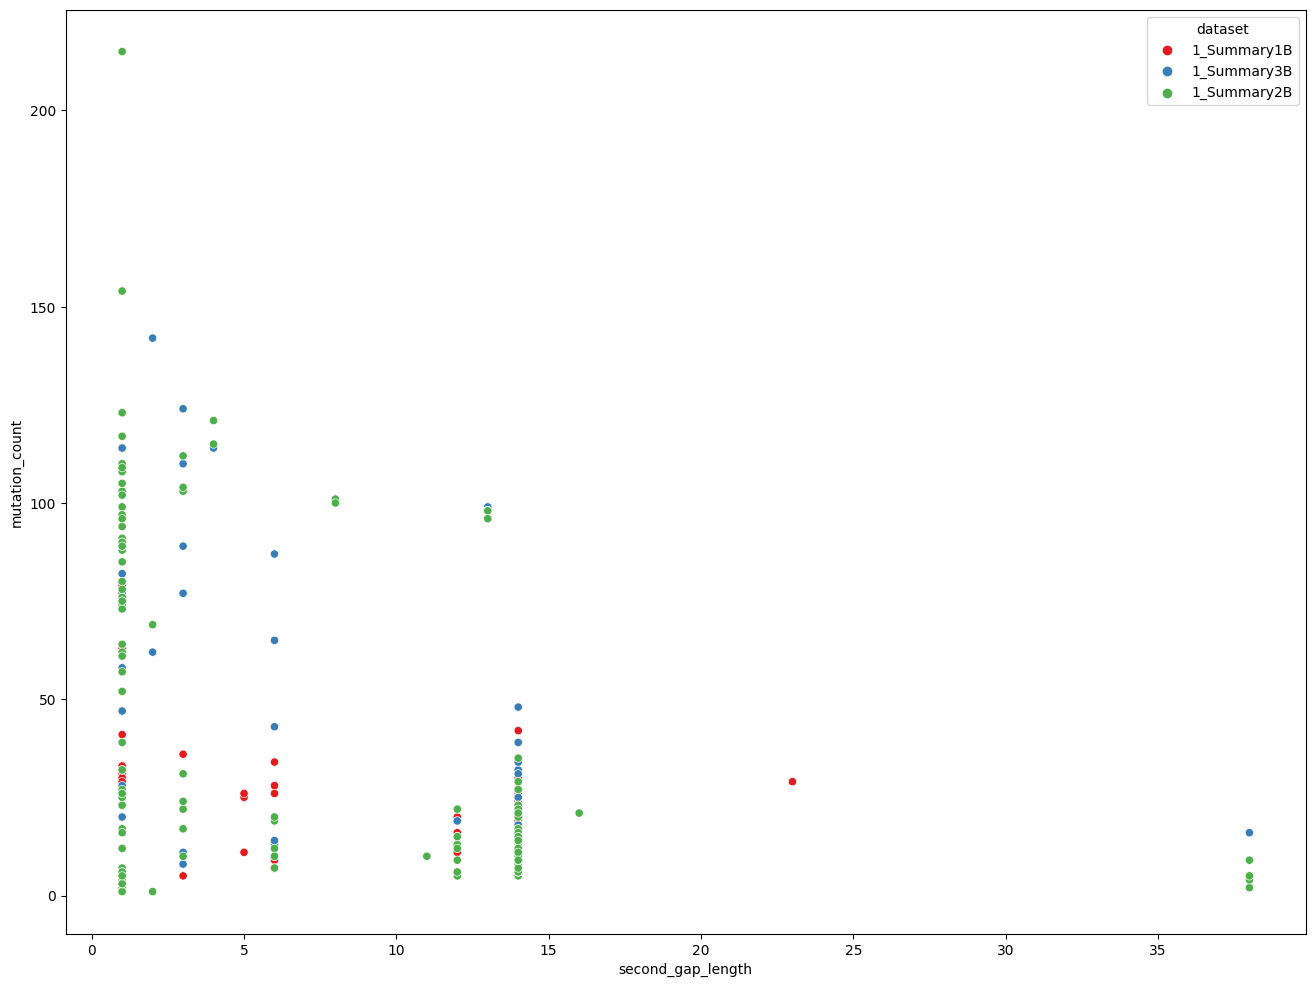

In [58]:
# Set the size of the figure
plt.figure(figsize=(16, 12))

# Create a scatter plot with points colored by 'dataset'
scatter_plot = sns.scatterplot(data=vj_correct_alignment_df, 
                               x='second_gap_length', 
                               y='mutation_count', 
                               hue='dataset', 
                               palette='Set1')  # Set1 is a color palette. You can choose another one.

# Show the plot
plt.show()


<Axes: >

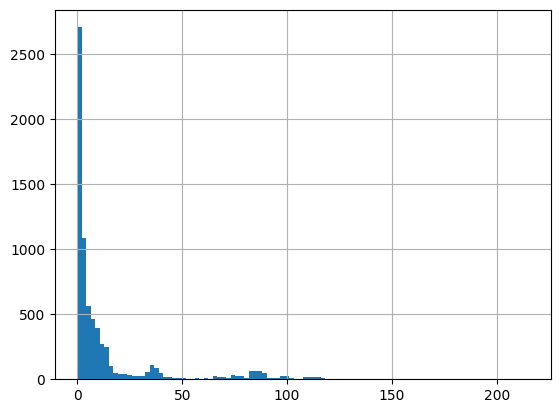

In [57]:
vj_correct_alignment_df["mutation_count"].hist(bins=100)

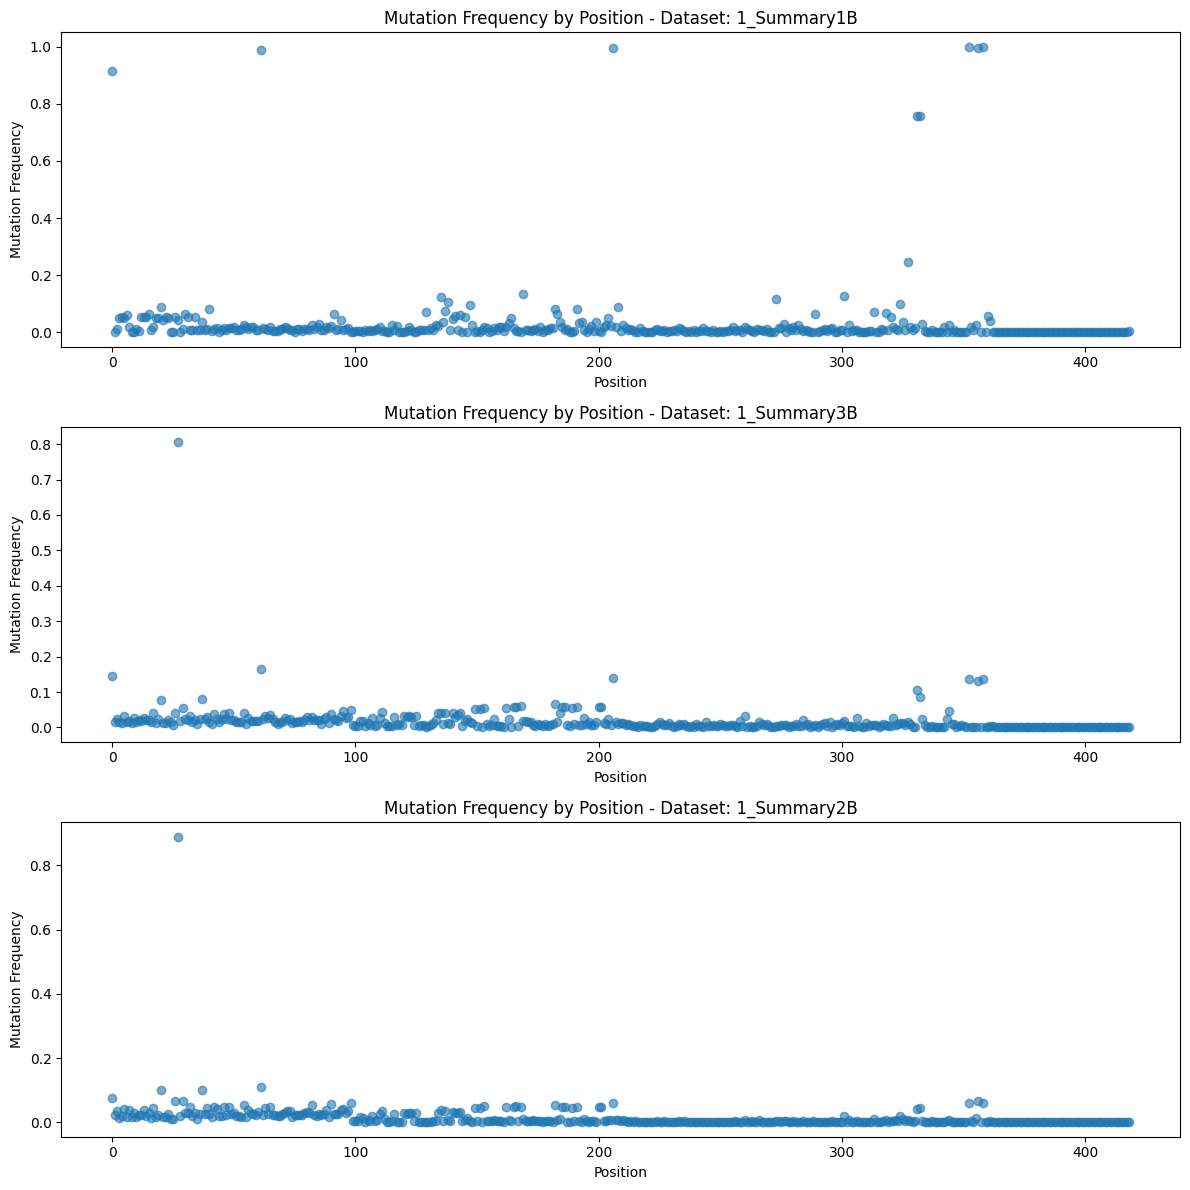

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Get the unique datasets
unique_datasets = vj_correct_alignment_df['dataset'].unique()

# Set up the figure and the array of subplots
fig, axs = plt.subplots(len(unique_datasets), 1, figsize=(12, 4*len(unique_datasets)))

# Iterate over unique datasets and create a subplot for each one
for index, dataset in enumerate(unique_datasets):
    # Get the ax for this subplot
    ax = axs[index] if len(unique_datasets) > 1 else axs
    
    # Filter DataFrame for this dataset and for mutation_count < 50
    filtered_df = vj_correct_alignment_df[(vj_correct_alignment_df['mutation_count'] < 50) & (vj_correct_alignment_df['dataset'] == dataset)]
    
    # Find the maximum value in the mutation_positions column to know the size of the array
    max_position = filtered_df['mutation_positions'].apply(lambda x: max(x) if x else 0).max()
    
    # Initialize the numpy array with zeroes
    mutation_counts_by_position = np.zeros(max_position + 1, dtype=int)
    
    # Iterate through the mutation_positions column and increment the corresponding position in the array
    for positions in filtered_df['mutation_positions']:
        if positions:  # Check if the list is not empty
            for position in positions:
                mutation_counts_by_position[position] += 1
    
    # Calculating Mutation Frequency by dividing by the total read count in the current dataset
    total_read_count = len(filtered_df)
    mutation_frequency_by_position = mutation_counts_by_position / total_read_count
    
    # Plotting
    ax.scatter(range(len(mutation_frequency_by_position)), mutation_frequency_by_position, alpha=0.6)
    ax.set_title(f'Mutation Frequency by Position - Dataset: {dataset}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Mutation Frequency')

plt.tight_layout()
plt.show()
